In [196]:
%pip install scikit-learn pandas numpy matplotlib tabulate seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 13.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3.8 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import re
pd.set_option("display.max_columns", None)
tf.get_logger().setLevel('INFO')
%cd /mnt

2023-08-09 19:53:26.514526: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-09 19:53:26.544083: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


/mnt


In [2]:
def unzip(path_to_zip_file, directory_to_extract_to):
    """
    Args:
        path_to_zip_file (str): 압축파일 경로
        directory_to_extract_to (str): 압축 풀고 저장할 경로
    """
    import zipfile
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)


In [3]:
data = pd.read_csv("Full-Dataset/processed/url_encoded_dataset.csv").sample(frac=1)
data = data.drop(["Unnamed: 0", "http.request.uri.query", "http.file_data", "http.request.full_uri", 
                  "tcp.options", "http.request.uri.path", "http.request.uri.query.dict", "http.file_data.dict", "http.request.uri.scheme"], axis="columns")
data["http.data"] = data["http.data"].fillna("")
original_data = data.copy()

# RNN학습시, URL정보를 바탕으로 분류를 진행할 수 있으므로 URL 정보를 삭제해야함.
data["tcp.payload"] = original_data["tcp.payload"].astype("str").apply(lambda x: " ".join([_ for _ in x.split(" ") if not (_.startswith("/DVWA") and _.endswith(".php"))]))

/tmp/ipykernel_27354/524550114.py:1: DtypeWarning: Columns (10,14,19,27) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("Full-Dataset/processed/url_encoded_dataset.csv").sample(frac=1)


In [4]:
# check for shannon entropy
unique_labels, counts = np.unique(data["Attack_type"], return_counts=True)
proportions = counts / len(data["Attack_type"])

# Calculate Shannon entropy
shannon_entropy = -np.sum(proportions * np.log(proportions))

"""
Degree of imbalance | Proportion of Minority Class
--------------------------------------------------
Mild	            | 20-40% of the data set
--------------------------------------------------
Moderate	        | 1-20% of the data set
--------------------------------------------------
Extreme	            | <1% of the data set
"""

print(f'{proportions*100=}\n\nShannon entropy: {shannon_entropy:.2f}')

proportions*100=array([76.18838217,  4.69668368,  2.04534729, 17.06958685])

Shannon entropy: 0.73


In [5]:
proportions

array([0.76188382, 0.04696684, 0.02045347, 0.17069587])

In [6]:
_ = pd.DataFrame(data["Attack_type"].value_counts())
_["percentage"] = proportions * 100
print(_.to_markdown())

| Attack_type   |   count |   percentage |
|:--------------|--------:|-------------:|
| Password      |   71035 |     76.1884  |
| XSS           |   15915 |      4.69668 |
| SQL_injection |    4379 |      2.04535 |
| Uploading     |    1907 |     17.0696  |


In [7]:
[
    (data["Attack_type"].value_counts() / len(data["Attack_type"])).mean(),
    (data["Attack_type"].value_counts() / len(data["Attack_type"])).std()
]

[0.25, 0.34748058249085034]

<Axes: xlabel='Attack_type', ylabel='count'>

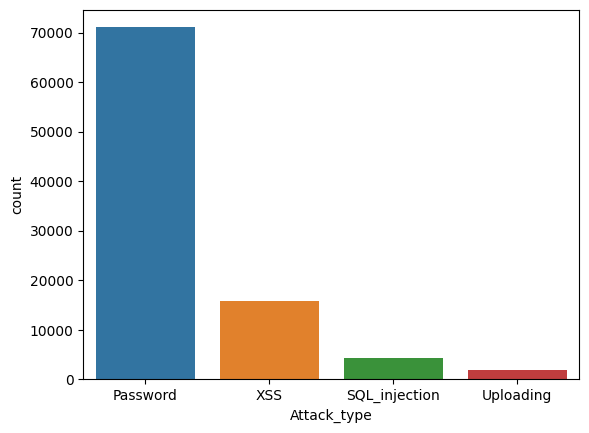

In [8]:
# Show Data Distribution
import seaborn as sns
labels = {key: i for i, key in enumerate(sorted(data["Attack_type"].unique()))}

sns.countplot(x=data["Attack_type"])

## RNN을 위한 전처리

In [9]:
# Tokenize values
tokenizer = Tokenizer(oov_token="<NUMBER>", filters='!"#$%&()*+,-./:?@[\\]^_`{|}~\t\n=',)
tokenizer.fit_on_texts(original_data["http.data"])
padded = pad_sequences(tokenizer.texts_to_sequences(original_data["http.data"]), padding="post", value=0)
data["http.data"] = padded.tolist()

In [10]:
word_index_dict = {val: key for key, val in tokenizer.word_index.items()}
pd.Series(tokenizer.texts_to_sequences(original_data["http.data"])).apply(lambda x: ", ".join([(word_index_dict)[_] for _ in x])).unique()

array(['', 'username, admin, password, 0, login, login',
       'username, admin, password, 00, login, login', ...,
       '0, 0, id, 7, submit, submitid, 3d57, 20and, 202739, 20in, 20, 28select, 20, 28char, 28113, 29, 2bchar, 28107, 29, 2bchar, 28120, 29, 2bchar, 28120, 29, 2bchar, 28113, 29, 2b, 28select, 20, 28case, 20when, 20, 282739, 3d2739, 29, 20then, 20char, 2849, 29, 20else, 20char, 2848, 29, 20end, 29, 29, 2bchar, 28113, 29, 2bchar, 28112, 29, 2bchar, 2898, 29, 2bchar, 28113, 29, 2bchar, 28113, 29, 29, 29, 20tyho',
       '0, 0, id, 4, 27, 29, 20and, 20, 28select, 206514, 20from, 20, 28select, 28sleep, 285, 29, 29, 29jyms, 29, 20and, 20, 28, 27aknh, 27, 3d, 27aknh, submit, submitid, 55',
       '0, 0, id, 9, 20and, 201390, 3d8998, 20evke, submit, submitid, 59'],
      dtype=object)

In [11]:
# Tokenize tcp.payload
tokenizer_payload = Tokenizer(oov_token="<PAD>")
tokenizer_payload.fit_on_texts(original_data["tcp.payload"].astype("str").apply(lambda x: " ".join([x.split(" ")[0],*x.split(" ")[2:]]))) # url 정보 제거
padded = pad_sequences(tokenizer_payload.texts_to_sequences(original_data["tcp.payload"].astype("str")), padding="post", value=0)
data["tcp.payload"] = padded.tolist()

In [12]:
data.head()

,tcp.len,tcp.checksum,tcp.ack,http.response,tcp.connection.fin,ip.dst_host,http.content_length,Attack_type,arp.opcode,tcp.srcport,tcp.payload,arp.dst.proto_ipv4,tcp.connection.synack,tcp.seq,http.referer,frame.time,tcp.dstport,tcp.connection.syn,tcp.connection.rst,ip.src_host,tcp.ack_raw,tcp.flags,arp.src.proto_ipv4,tcp.flags.ack,arp.hw.size,0,GET,POST,TRACE,HTTP/1.0,HTTP/1.1,http.request.uri.netloc,http.data
55728,221.0,0x00008228,1.0,0.0,0.0,192.168.0.128,0.0,Password,0.0,42448.0,"[15, 1, 27, 1, 5, 4, 2, 9, 6, 7, 2, 8, 10, 11,...",0,0.0,1.0,0.0,2021 19:56:13.240856000,80.0,0.0,0.0,192.168.0.170,3.769575e+09,0x00000018,0,1.0,0.0,False,True,False,False,True,False,192.168.0.128,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
22130,86.0,0x00009538,1.0,0.0,0.0,192.168.0.128,0.0,Password,0.0,60106.0,"[15, 1, 27, 1, 5, 4, 2, 9, 6, 7, 2, 8, 10, 11,...",0,0.0,1.0,0.0,2021 17:55:52.549133000,80.0,0.0,0.0,192.168.0.170,2.098166e+09,0x00000018,0,1.0,0.0,False,True,False,False,True,False,192.168.0.128,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
26843,86.0,0x0000dc94,1.0,0.0,0.0,192.168.0.128,0.0,Password,0.0,45268.0,"[15, 1, 27, 1, 5, 4, 2, 9, 6, 7, 2, 8, 10, 11,...",0,0.0,1.0,0.0,2021 18:15:32.585673000,80.0,0.0,0.0,192.168.0.170,3.313151e+09,0x00000018,0,1.0,0.0,False,True,False,False,True,False,192.168.0.128,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
80896,0.0,0x0000b6c7,486.0,0.0,0.0,192.168.0.128,0.0,XSS,0.0,59504.0,"[33, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,0.0,122.0,0,2021 18:15:16.208999000,80.0,0.0,0.0,192.168.0.170,1.823454e+08,0x00000010,0,1.0,0.0,True,False,False,False,False,False,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
63083,221.0,0x0000a3ab,1.0,0.0,0.0,192.168.0.128,0.0,Password,0.0,35080.0,"[15, 1, 27, 1, 5, 4, 2, 9, 6, 7, 2, 8, 10, 11,...",0,0.0,1.0,0.0,2021 20:20:30.884110000,80.0,0.0,0.0,192.168.0.170,2.852531e+09,0x00000018,0,1.0,0.0,False,True,False,False,True,False,192.168.0.128,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [13]:
original_data.head()

,tcp.len,tcp.checksum,tcp.ack,http.response,tcp.connection.fin,ip.dst_host,http.content_length,Attack_type,arp.opcode,tcp.srcport,tcp.payload,arp.dst.proto_ipv4,tcp.connection.synack,tcp.seq,http.referer,frame.time,tcp.dstport,tcp.connection.syn,tcp.connection.rst,ip.src_host,tcp.ack_raw,tcp.flags,arp.src.proto_ipv4,tcp.flags.ack,arp.hw.size,0,GET,POST,TRACE,HTTP/1.0,HTTP/1.1,http.request.uri.netloc,http.data
55728,221.0,0x00008228,1.0,0.0,0.0,192.168.0.128,0.0,Password,0.0,42448.0,GET /DVWA/login.php HTTP/1.0\nHost: 192.168.0....,0,0.0,1.0,0.0,2021 19:56:13.240856000,80.0,0.0,0.0,192.168.0.170,3.769575e+09,0x00000018,0,1.0,0.0,False,True,False,False,True,False,192.168.0.128,
22130,86.0,0x00009538,1.0,0.0,0.0,192.168.0.128,0.0,Password,0.0,60106.0,GET /DVWA/login.php HTTP/1.0\nHost: 192.168.0....,0,0.0,1.0,0.0,2021 17:55:52.549133000,80.0,0.0,0.0,192.168.0.170,2.098166e+09,0x00000018,0,1.0,0.0,False,True,False,False,True,False,192.168.0.128,
26843,86.0,0x0000dc94,1.0,0.0,0.0,192.168.0.128,0.0,Password,0.0,45268.0,GET /DVWA/login.php HTTP/1.0\nHost: 192.168.0....,0,0.0,1.0,0.0,2021 18:15:32.585673000,80.0,0.0,0.0,192.168.0.170,3.313151e+09,0x00000018,0,1.0,0.0,False,True,False,False,True,False,192.168.0.128,
80896,0.0,0x0000b6c7,486.0,0.0,0.0,192.168.0.128,0.0,XSS,0.0,59504.0,NaN,0,0.0,122.0,0,2021 18:15:16.208999000,80.0,0.0,0.0,192.168.0.170,1.823454e+08,0x00000010,0,1.0,0.0,True,False,False,False,False,False,NaN,
63083,221.0,0x0000a3ab,1.0,0.0,0.0,192.168.0.128,0.0,Password,0.0,35080.0,GET /DVWA/login.php HTTP/1.0\nHost: 192.168.0....,0,0.0,1.0,0.0,2021 20:20:30.884110000,80.0,0.0,0.0,192.168.0.170,2.852531e+09,0x00000018,0,1.0,0.0,False,True,False,False,True,False,192.168.0.128,


In [14]:
def zipFile(fileName):
    import shutil
    shutil.make_archive(fileName,"zip", fileName)

## DNN을 위한 전처리

In [15]:
# process time data into hour
def time_to_sec(time):
    hour, minute, second = list(map(float, time[5:].strip().split(":")))
    sec = hour*3600 + minute*60 + second
    return sec / 3600
data["frame.time"] = original_data["frame.time"].apply(time_to_sec)

In [16]:
# tcp.checksum float로 변경
data["tcp.checksum"] = original_data["tcp.checksum"].astype("str").apply(lambda x: int(x[2:] if x[2:] else "0", 16))

In [17]:
# tcp.flag float로 변경
data["tcp.flags"] = original_data["tcp.flags"].astype("str").apply(lambda x: int(x[2:] if x[2:] else "0", 16))

In [18]:
# tcp.ack_raw 정규화
data["tcp.ack_raw"] = (original_data["tcp.ack_raw"] - original_data["tcp.ack_raw"].mean()) / original_data["tcp.ack_raw"].std()

In [19]:
# tcp.ack 정규화
data["tcp.ack"] = (original_data["tcp.ack"] - original_data["tcp.ack"].mean()) / original_data["tcp.ack"].std()

In [20]:
for feature in ["GET", "POST", "TRACE", "HTTP/1.0", "HTTP/1.1"]:
    data[feature] = original_data[feature].apply(int)

In [21]:
# http.referer는 [0.0, '0.0', '0', '127.0.0.1'] 의 값만을 갖고 있으므로, 의미가 없음.
data = data.drop(["http.referer"], axis="columns") 

In [22]:
data = data.drop(["0"], axis="columns")

In [23]:
# DNN을 할 columns
DNN_COLS = ['frame.time', 'tcp.checksum', 'http.response',
       'http.content_length',
       'tcp.connection.rst', 'arp.hw.size', 'tcp.len',
       'tcp.seq', 'tcp.connection.syn',
       'tcp.flags.ack', 'tcp.ack_raw', 'tcp.connection.fin', 'tcp.dstport',
       'tcp.flags', 'tcp.ack', 'tcp.connection.synack', 
       'tcp.srcport', 'arp.opcode', 'GET', 'POST', 'TRACE', 'HTTP/1.0',
       'HTTP/1.1']
data[DNN_COLS].head(10)

,frame.time,tcp.checksum,http.response,http.content_length,tcp.connection.rst,arp.hw.size,tcp.len,tcp.seq,tcp.connection.syn,tcp.flags.ack,tcp.ack_raw,tcp.connection.fin,tcp.dstport,tcp.flags,tcp.ack,tcp.connection.synack,tcp.srcport,arp.opcode,GET,POST,TRACE,HTTP/1.0,HTTP/1.1
55728,19.937011,33320,0.0,0.0,0.0,0.0,221.0,1.0,0.0,1.0,1.320338,0.0,80.0,24,-0.263640,0.0,42448.0,0.0,1,0,0,1,0
22130,17.931264,38200,0.0,0.0,0.0,0.0,86.0,1.0,0.0,1.0,0.006861,0.0,80.0,24,-0.263640,0.0,60106.0,0.0,1,0,0,1,0
26843,18.259052,56468,0.0,0.0,0.0,0.0,86.0,1.0,0.0,1.0,0.961657,0.0,80.0,24,-0.263640,0.0,45268.0,0.0,1,0,0,1,0
80896,18.254502,46791,0.0,0.0,0.0,0.0,0.0,122.0,0.0,1.0,-1.498687,0.0,80.0,16,4.077335,0.0,59504.0,0.0,0,0,0,0,0
63083,20.341912,41899,0.0,0.0,0.0,0.0,221.0,1.0,0.0,1.0,0.599678,0.0,80.0,24,-0.263640,0.0,35080.0,0.0,1,0,0,1,0
48860,19.553590,17325,0.0,0.0,0.0,0.0,221.0,1.0,0.0,1.0,0.899996,0.0,80.0,24,-0.263640,0.0,51142.0,0.0,1,0,0,1,0
4222,16.888010,11087,0.0,0.0,0.0,0.0,86.0,1.0,0.0,1.0,0.530456,0.0,80.0,24,-0.263640,0.0,37478.0,0.0,1,0,0,1,0
30748,18.536822,39173,0.0,0.0,0.0,0.0,86.0,1.0,0.0,1.0,1.070418,0.0,80.0,24,-0.263640,0.0,56318.0,0.0,1,0,0,1,0
45007,19.334724,47357,0.0,37.0,0.0,0.0,260.0,1.0,0.0,1.0,0.852608,0.0,80.0,24,-0.263640,0.0,40232.0,0.0,0,1,0,1,0
92085,19.747763,31419,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.641983,0.0,80.0,2,-0.272590,0.0,32926.0,0.0,0,0,0,0,0


## 데이터 분할

In [24]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.3)
datas = [train_test_split(data, test_size=0.3) for _ in range(50)]

In [25]:
datas_ = []
def to_onehot_wrapper(labels):
    def to_onehot(x):
        l = [0 for _ in range(labels.__len__())]
        l[labels[x]] = 1
        return l
    return to_onehot
for idx, (train, test) in enumerate(datas):
    labels = {key: i for i, key in enumerate(sorted(test["Attack_type"].unique()))}
    test_X, test_Y = test.drop(["Attack_type"], axis="columns"), np.stack(test["Attack_type"].apply(to_onehot_wrapper(labels)))
    train_X, train_Y =  train.drop(["Attack_type"], axis="columns"), np.stack(train["Attack_type"].apply(to_onehot_wrapper(labels)))
    datas_.append([test_X, test_Y, train_X, train_Y])


In [26]:
labels = {key: i for i, key in enumerate(sorted(test["Attack_type"].unique()))}
def to_onehot(x):
    l = [0 for _ in range(labels.__len__())]
    l[labels[x]] = 1
    return l
test_X, test_Y = test.drop(["Attack_type"], axis="columns"), np.stack(test["Attack_type"].apply(to_onehot))
train_X, train_Y =  train.drop(["Attack_type"], axis="columns"), np.stack(train["Attack_type"].apply(to_onehot))

## RNN 실행

In [27]:
import keras.backend as K
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


In [28]:
payload_test_X ,RNN_test_X =  np.stack(test["tcp.payload"]),np.stack(test["http.data"])
payload_train_X ,RNN_train_X =  np.stack(train["tcp.payload"]),np.stack(train["http.data"])

payload_test_Xs = []
RNN_test_Xs = []
payload_train_Xs = []
RNN_train_Xs = []
for idx, _dt in enumerate(datas):
    _train, _test = _dt
    print(f"{_train.shape=}, {_test.shape=}")
    payload_test_Xs.append(
        np.stack(_test["tcp.payload"])
    ) 
    RNN_test_Xs.append(
        np.stack(_test["http.data"])
    ) 
    
    payload_train_Xs.append(
        np.stack(_train["tcp.payload"])
    ) 
    RNN_train_Xs.append(
        np.stack(_train["http.data"])
    ) 
    

_train.shape=(65265, 31), _test.shape=(27971, 31)
_train.shape=(65265, 31), _test.shape=(27971, 31)
_train.shape=(65265, 31), _test.shape=(27971, 31)
_train.shape=(65265, 31), _test.shape=(27971, 31)
_train.shape=(65265, 31), _test.shape=(27971, 31)
_train.shape=(65265, 31), _test.shape=(27971, 31)
_train.shape=(65265, 31), _test.shape=(27971, 31)
_train.shape=(65265, 31), _test.shape=(27971, 31)
_train.shape=(65265, 31), _test.shape=(27971, 31)
_train.shape=(65265, 31), _test.shape=(27971, 31)


In [29]:
file_data_vocab_size = tokenizer.word_index.keys().__len__() + 1
file_data_input_dim = RNN_train_X.shape[1]

In [30]:
import os

layers = [
            keras.layers.Embedding(file_data_vocab_size, 128, input_length=file_data_input_dim),
            keras.layers.LSTM(128, dropout=0.7, activation="tanh"),
            keras.layers.Dense(100, activation=tf.nn.relu),
            keras.layers.Dense(4, activation='softmax'),
        ]

compileArgs = {
    "loss": tf.keras.losses.CategoricalCrossentropy(), 
    "optimizer": tf.keras.optimizers.Adam(learning_rate=.005), 
    "metrics": ["accuracy", f1_score, precision, recall],
}
RNN_models = []
for idx, (RNN_train_X, (_, _, _, train_Y)) in enumerate(zip(RNN_train_Xs, datas_)):
    RNN_model = keras.Sequential(
        layers = [
            keras.layers.Embedding(file_data_vocab_size, 128, input_length=file_data_input_dim),
            keras.layers.LSTM(128, dropout=0.7, activation="tanh"),
            keras.layers.Dense(100, activation=tf.nn.relu),
            keras.layers.Dense(4, activation='softmax'),
        ]
    )
    RNN_model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=.005), 
        metrics=["accuracy", f1_score, precision, recall],
    )
    print(f"repeat no.{idx+1}")
    RNN_model.fit(RNN_train_X, train_Y, epochs=15, batch_size=128)
    RNN_models.append(RNN_model)
    # RNN_model.save("http_data_RNN.model")
    # zipFile("http_data_RNN.model")

2023-08-09 09:04:38.204848: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-09 09:04:38.208584: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-09 09:04:38.208878: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-09 09:04:38.211248: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-09 09:04:38.211425: I tensorflow/compile

repeat no.1
Epoch 1/15


2023-08-09 09:04:40.947145: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-09 09:04:41.040775: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-09 09:04:41.043532: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2318032220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-09 09:04:41.043555: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2023-08-09 09:04:41.046726: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-09 09:04:41.119590: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

510/510 [==============================] - 21s 37ms/step - loss: 0.5633 - accuracy: 0.8049 - f1_score: 0.8025 - precision: 0.8031 - recall: 0.8022
Epoch 2/15
510/510 [==============================] - 8s 15ms/step - loss: 0.5469 - accuracy: 0.8085 - f1_score: 0.8085 - precision: 0.8085 - recall: 0.8084
Epoch 3/15
510/510 [==============================] - 6s 12ms/step - loss: 0.6221 - accuracy: 0.7889 - f1_score: 0.7899 - precision: 0.7924 - recall: 0.7875
Epoch 4/15
510/510 [==============================] - 6s 12ms/step - loss: 0.4022 - accuracy: 0.8290 - f1_score: 0.8290 - precision: 0.8290 - recall: 0.8290
Epoch 5/15
510/510 [==============================] - 6s 11ms/step - loss: 0.3697 - accuracy: 0.8415 - f1_score: 0.8415 - precision: 0.8415 - recall: 0.8415
Epoch 6/15
510/510 [==============================] - 6s 12ms/step - loss: 0.3682 - accuracy: 0.8416 - f1_score: 0.8416 - precision: 0.8416 - recall: 0.8416
Epoch 7/15
510/510 [==============================] - 6s 12ms/step -

In [31]:
payload_vocab_size = tokenizer_payload.word_index.keys().__len__() + 1
payload_input_dim = payload_train_X.shape[1]

In [32]:
layers = [
            keras.layers.Embedding(payload_vocab_size, 128, input_length=payload_input_dim),
            keras.layers.LSTM(128, dropout=0.7),
            keras.layers.Dense(100, activation="relu"),
            keras.layers.Dense(4, activation='softmax'),
        ]
payload_RNN_model_args = {
    "loss": tf.keras.losses.CategoricalCrossentropy(), 
    "optimizer": "adam", 
    "metrics": ["accuracy", f1_score, precision, recall],
}
payload_models = []
for idx, (payload_train_X, (_, _, _, train_Y)) in enumerate(zip(payload_train_Xs, datas_)):
    payload_RNN_model = keras.Sequential(layers = [
            keras.layers.Embedding(payload_vocab_size, 128, input_length=payload_input_dim),
            keras.layers.LSTM(128, dropout=0.7),
            keras.layers.Dense(100, activation="relu"),
            keras.layers.Dense(4, activation='softmax'),
        ])
    payload_RNN_model.compile(
        loss= tf.keras.losses.CategoricalCrossentropy(), 
        optimizer= "adam", 
        metrics= ["accuracy", f1_score, precision, recall],
    )
    print(f"repeat no.{idx+1}")
    payload_RNN_model.fit(payload_train_X, train_Y, epochs=15, batch_size=128)
    payload_models.append(payload_RNN_model)


repeat no.1
Epoch 1/15
510/510 [==============================] - 15s 28ms/step - loss: 0.6473 - accuracy: 0.7793 - f1_score: 0.7698 - precision: 0.7724 - recall: 0.7682
Epoch 2/15
510/510 [==============================] - 7s 15ms/step - loss: 0.4435 - accuracy: 0.8706 - f1_score: 0.8729 - precision: 0.8876 - recall: 0.8602
Epoch 3/15
510/510 [==============================] - 7s 14ms/step - loss: 0.2071 - accuracy: 0.9369 - f1_score: 0.9382 - precision: 0.9567 - recall: 0.9215
Epoch 4/15
510/510 [==============================] - 7s 14ms/step - loss: 0.2809 - accuracy: 0.9210 - f1_score: 0.9212 - precision: 0.9216 - recall: 0.9208
Epoch 5/15
510/510 [==============================] - 7s 13ms/step - loss: 0.5253 - accuracy: 0.8206 - f1_score: 0.8206 - precision: 0.8208 - recall: 0.8205
Epoch 6/15
510/510 [==============================] - 7s 14ms/step - loss: 0.5226 - accuracy: 0.8213 - f1_score: 0.8213 - precision: 0.8213 - recall: 0.8213
Epoch 7/15
510/510 [=========================

In [33]:
file_data_predictions = []
for RNN_model, RNN_test_X in zip(RNN_models, RNN_test_Xs):
    file_data_predictions.append(RNN_model.predict(RNN_test_X))

875/875 [==============================] - 3s 3ms/step


In [34]:
payload_predictions = []
for payload_RNN_model, payload_test_X in zip(payload_models, payload_test_Xs):
    payload_predictions.append(RNN_model.predict(payload_test_X))

875/875 [==============================] - 3s 3ms/step


In [35]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score

In [36]:
file_data_confusion_matrixs = []
for file_data_prediction, (_, test_Y, _, _) in zip(file_data_predictions, datas_):
    p = pd.DataFrame(confusion_matrix(np.argmax(test_Y, axis=1), np.argmax(file_data_prediction, axis=1)),index="TRUE_"+pd.Series(labels.keys()), columns="PRED_"+pd.Series(labels.keys()))
    file_data_confusion_matrixs.append(p)

In [37]:
payload_confusion_matrixs = []
for payload_prediction, (_, test_Y, _, _) in zip(payload_predictions, datas_):
    p = \
    pd.DataFrame(confusion_matrix(np.argmax(test_Y, axis=1), np.argmax(payload_prediction, axis=1)),index="TRUE_"+pd.Series(labels.keys()), columns="PRED_"+pd.Series(labels.keys()))
    payload_confusion_matrixs.append(p)

## DNN 실행

In [27]:
import keras.backend as K
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


In [28]:
DNN_layers = [
        keras.layers.Dense(4196, activation="relu"),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dense(len(labels.keys()), activation="softmax"),
    ]
DNN_compile = {
    "loss": tf.keras.losses.CategoricalCrossentropy(), 
    "optimizer": "adam", 
    "metrics": ["accuracy", f1_score, precision, recall],
}
# predictions = []
DNN_models = []
DNN_predictions = []


In [30]:
for idx, (test_X, test_Y, train_X, train_Y) in list(enumerate(datas_))[:20]:
    DNN_model = keras.Sequential(layers=DNN_layers.copy())
    DNN_model.compile(**DNN_compile)
    print(f"repeat no.{idx+1}")
    DNN_model.fit(train_X[DNN_COLS], train_Y, epochs=15, batch_size=64)
    DNN_models.append(DNN_model)
    DNN_prediction = DNN_model.predict(test_X[DNN_COLS])
    DNN_predictions.append(DNN_prediction)

repeat no.1
Epoch 1/15


2023-08-09 19:54:53.932212: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-09 19:54:53.937057: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-09 19:54:53.937670: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-09 19:54:53.941062: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-09 19:54:53.941594: I tensorflow/compile

1020/1020 [==============================] - 8s 6ms/step - loss: 18.9584 - accuracy: 0.8254 - f1_score: 0.8225 - precision: 0.8279 - recall: 0.8179
Epoch 2/15
1020/1020 [==============================] - 6s 6ms/step - loss: 0.3557 - accuracy: 0.9017 - f1_score: 0.9013 - precision: 0.9038 - recall: 0.8989
Epoch 3/15
1020/1020 [==============================] - 6s 6ms/step - loss: 0.2472 - accuracy: 0.9334 - f1_score: 0.9331 - precision: 0.9346 - recall: 0.9316
Epoch 4/15
1020/1020 [==============================] - 6s 6ms/step - loss: 0.4649 - accuracy: 0.9217 - f1_score: 0.9215 - precision: 0.9230 - recall: 0.9202
Epoch 5/15
1020/1020 [==============================] - 6s 6ms/step - loss: 0.1972 - accuracy: 0.9495 - f1_score: 0.9495 - precision: 0.9500 - recall: 0.9489
Epoch 6/15
1020/1020 [==============================] - 6s 6ms/step - loss: 0.2030 - accuracy: 0.9476 - f1_score: 0.9476 - precision: 0.9481 - recall: 0.9471
Epoch 7/15
1020/1020 [==============================] - 6s 6ms

In [ ]:
for idx, (test_X, test_Y, train_X, train_Y) in list(enumerate(datas_))[20:]:
    idx += 20
    DNN_model = keras.Sequential(layers=DNN_layers.copy())
    DNN_model.compile(**DNN_compile)
    print(f"repeat no.{idx+1}")
    DNN_model.fit(train_X[DNN_COLS], train_Y, epochs=15, batch_size=64)
    DNN_models.append(DNN_model)
    DNN_prediction = DNN_model.predict(test_X[DNN_COLS])
    DNN_predictions.append(DNN_prediction)

In [40]:
DNN_confusion_matrix = []

for prediction, (test_X, test_Y, train_X, train_Y) in zip(DNN_predictions, datas_):
    DNN_confusion_matrix.append(pd.DataFrame(confusion_matrix(np.argmax(test_Y, axis=1), np.argmax(prediction, axis=1)), index="TRUE_"+pd.Series(labels.keys()), columns="PRED_"+pd.Series(labels.keys())))
    # .to_markdown(tablefmt="grid")

In [41]:
# ensemble model
result_list = []
result_weight_list = []
for DNN_prediction, file_data_prediction in zip(DNN_predictions, file_data_predictions):
    result = np.array([([d1,d2,d3,d4] if max([d1,d2,d3,d4])==d4 else [p1, p2 ,p3, p4] if max([p1, p2, p3, p4]) in [p2, p3, p4] else [d1, 0, 0, d4]) for (d1,d2,d3,d4),(p1,p2,p3,p4) in zip(DNN_prediction, file_data_prediction)])
    result_weight = np.array([([d1,d2,d3,d4] if max([d1,d2,d3,d4])==d4 else [p1, p2 ,p3, p4] if max([p1, p2, p3, p4]) in [p2, p3, p4] else [d1, 0, 0, d4*2]) for (d1,d2,d3,d4),(p1,p2,p3,p4) in zip(DNN_prediction, file_data_prediction)])
    result_list.append(result)
    result_weight_list.append(result_weight)

In [ ]:
from pprint import pprint 

def printnn(*args, end="\n\n", **kwargs):
    return print(*args, end=end, **kwargs)
def get_matrix_vals(cnf_matrix, DEBUG=False, _dict_=True):
    length = int(cnf_matrix.sum().sum())
    index = ["PW_Injection", "SQLi", "File_Inclusion", "XSS"]
    _FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  # column
    _FP.index = index
    if DEBUG: printnn("_FP\n",_FP)
    _FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix) # rows
    _FN.index = index
    if DEBUG: printnn("_FN\n",_FN)
    _TP = pd.Series(np.diag(cnf_matrix), index=index) 
    if DEBUG: printnn("_TP\n",_TP)
    _TN = pd.Series([length for _ in range(4)], index=index) - (_FP + _FN + _TP) 
    
    if DEBUG: printnn(_TN)
    if not _dict_: return {
        "FP":_FP, "FN":_FN, "TP":_TP, "TN":_TN, "length": length
    }
    return {"FP":_FP.to_dict(), "FN":_FN.to_dict(), "TP":_TP.to_dict(), "TN":_TN.to_dict(), "length": length}

def scores_matrix(confusion_matrix, DEBUG=False):
    confusion_matrix_dict = get_matrix_vals(confusion_matrix, _dict_=False)
    FP, FN, TP, TN = confusion_matrix_dict["FP"], confusion_matrix_dict["FN"], confusion_matrix_dict["TP"], confusion_matrix_dict["TN"], 
    accuracy = (TP+TN) / (TP+TN+FP+FN)
    precision = (TP) / (TP + FP)
    recall = (TP) / (TP + FN)
    f1_score = 1 / (
        (1/precision + 1/recall) / 2
    )
    result = pd.concat([accuracy, precision, recall, f1_score], axis=1)
    result.columns=["accuracy", "precision", "recall", "f1_score"]
    result.index = ["PW_Injection", "SQLi", "File_Inclusion", "XSS"]
    if DEBUG: pprint(result)
    return result

In [42]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score
result_confusion_matrix_list = []
result_weight_confusion_matrix_list = []
for (test_X, test_Y, train_X, train_Y), (result, result_weight) in zip(datas_,zip(result_list, result_weight_list)):
    print("result - default")
    precision_Score, recall_Score, f1_Score = precision_score(np.argmax(test_Y, axis=1), np.argmax(result, axis=1), average="macro"),\
        recall_score(np.argmax(test_Y, axis=1), np.argmax(result, axis=1), average="macro"), \
            f1_score(np.argmax(test_Y, axis=1), np.argmax(result, axis=1), average="macro")
            
    print(f"""{precision_Score=}\t{recall_Score=}\t{f1_Score=}""")
    result_confusion_matrix = pd.DataFrame(confusion_matrix(np.argmax(test_Y, axis=1), np.argmax(result, axis=1)), index="TRUE_"+pd.Series(labels.keys()), columns="PRED_"+pd.Series(labels.keys()))
    print(
    result_confusion_matrix.to_markdown(tablefmt="grid")
    )
    print()
    print()
    print("result-weighted")
    precision_Score, recall_Score, f1_Score = precision_score(np.argmax(test_Y, axis=1), np.argmax(result_weight, axis=1), average="macro"),\
        recall_score(np.argmax(test_Y, axis=1), np.argmax(result_weight, axis=1), average="macro"), \
            f1_score(np.argmax(test_Y, axis=1), np.argmax(result_weight, axis=1), average="macro")
                
            
    print(f"""{precision_Score=}\t{recall_Score=}\t{f1_Score=}\tf1_micro={f1_score(np.argmax(test_Y, axis=1), np.argmax(result_weight, axis=1), average="micro")}""")
    result_weight_confusion_matrix = pd.DataFrame(confusion_matrix(np.argmax(test_Y, axis=1), np.argmax(result_weight, axis=1)), index="TRUE_"+pd.Series(labels.keys()), columns="PRED_"+pd.Series(labels.keys()))
    print(
    result_weight_confusion_matrix.to_markdown(tablefmt="grid")
    )
    result_confusion_matrix_list.append(result_confusion_matrix)
    result_weight_confusion_matrix_list.append(result_weight_confusion_matrix)

result - default
precision_Score=0.9747321353243905	recall_Score=0.8737884534344711	f1_Score=0.9022798658184719
+--------------------+-----------------+----------------------+------------------+------------+
|                    |   PRED_Password |   PRED_SQL_injection |   PRED_Uploading |   PRED_XSS |
+====================+=================+======================+==================+============+
| TRUE_Password      |           21310 |                    0 |                0 |          0 |
+--------------------+-----------------+----------------------+------------------+------------+
| TRUE_SQL_injection |               0 |                 1329 |                0 |          0 |
+--------------------+-----------------+----------------------+------------------+------------+
| TRUE_Uploading     |               0 |                    0 |              586 |          0 |
+--------------------+-----------------+----------------------+------------------+------------+
| TRUE_XSS           |  

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, accuracy_score

for name, _matrix, _prediction, _dt in \
    [
        ["DNN", DNN_confusion_matrix, DNN_predictions, datas_], # DNN 
        ["result_confusion_matrix", result_confusion_matrix_list, result_list, datas_], # DNN + file_data(user form)
        ["result_weight_confusion_matrix", result_weight_confusion_matrix_list, result_weight_list, datas_], # DNN + file_data(user form) modified
        ["file_data", file_data_confusion_matrixs, file_data_predictions, datas_], # file_data(user_form) LSTM
        ["payload", payload_confusion_matrixs, payload_predictions, datas_], # payload_data LSTM
    ]:
    print("\033[95m\033[92m", end="")
    print("-"*60)
    print(name)
    print("-"*60, end="\033[0m\n")
    for idx, (_d, (_m, _p)) in enumerate(zip(_dt, zip(_matrix, _prediction))):
        test_Y = _d[1]
        print(f"attempt ({idx+1})")
        print(f"""accuracy={accuracy_score(np.argmax(test_Y, axis=1), np.argmax(_p, axis=1))}""")
        print(f"""f1_macro={f1_score(np.argmax(test_Y, axis=1), np.argmax(_p, axis=1), average="macro", zero_division=0)}""")
        print(f"""f1_weighted={f1_score(np.argmax(test_Y, axis=1), np.argmax(_p, axis=1), average="weighted")}""")
        print(f"""precision_macro={precision_score(np.argmax(test_Y, axis=1), np.argmax(_p, axis=1), average="macro")}""", end="\t")
        print(f"""recall_macro={recall_score(np.argmax(test_Y, axis=1), np.argmax(_p, axis=1), average="macro")}""")
        print(f"""accuracy={accuracy_score(np.argmax(test_Y, axis=1), np.argmax(_p, axis=1)).tolist()}""")
        print(f"""f1_scores={f1_score(np.argmax(test_Y, axis=1), np.argmax(_p, axis=1), average=None, zero_division=0).tolist()}""")
        print(f"""precision={precision_score(np.argmax(test_Y, axis=1), np.argmax(_p, axis=1), average=None).tolist()}""")
        print(f"""recall={recall_score(np.argmax(test_Y, axis=1), np.argmax(_p, axis=1), average=None).tolist()}""")
        print(_m.to_markdown(tablefmt="grid"))
        _m.to_csv(os.path.join("confusion_matrix", f"{name}_attempt_{str(idx+1).zfill(2)}.csv"))
        pd.DataFrame(test_Y, columns=["PW_Injection", "SQLi", "File_Inclusion", "XSS"]).to_csv(os.path.join("prediction_result", f"testY_attempt_{str(idx+1).zfill(2)}.csv"))
        pd.DataFrame(_p, columns=["PW_Injection", "SQLi", "File_Inclusion", "XSS"]).to_csv(os.path.join("prediction_result", f"{name}_attempt_{str(idx+1).zfill(2)}.csv"))
        print()
    print()
    

In [49]:
file_data_confusion_matrixs[0].sum()

PRED_Password         25738
PRED_SQL_injection     1329
PRED_Uploading          586
PRED_XSS                318
dtype: int64

In [59]:
from pprint import pprint

i = 0
confusion_matrix = DNN_confusion_matrix
# _ 는 TRUE_ 이다.
# _.replace("TRUE_", "PRED_") 는 PRED 이다.
# TP: confusion_matrix[i].loc[_][_.replace("TRUE_", "PRED_")]
# TN: confusion_matrix[i][_.replace("TRUE_", "PRED_")].loc[_]
# FP: confusion_matrix[i].loc[_][_.replace("TRUE_", "PRED_")]
# FN: confusion_matrix[i].loc[_][_.replace("TRUE_", "PRED_")]
def index_not(df, index_name):
    return df.loc[df.index.str[-5:]!=index_name]
def column_not(df, column_name):
    return df.loc[:,[_ for _ in df.columns if _!=column_name]]

def TP(df, true_col_name):
    index_name = true_col_name.replace("TRUE_", "PRED_")
    return df.loc[true_col_name][index_name]

def TN(df, true_col_name):
    index_name = true_col_name.replace("TRUE_", "PRED_")
    return column_not(index_not(df, index_name), true_col_name).sum()

def FP(df, true_col_name):
    index_name = true_col_name.replace("TRUE_", "PRED_")
    return index_not(df.loc[true_col_name], index_name)

def FN(df, true_col_name):
    index_name = true_col_name.replace("TRUE_", "PRED_")
    return column_not(df, true_col_name)[index_name]




def accuracy(df, _):
    divisor = (TP(df, _).sum() + TN(df, _).sum()) 
    dividor = (TP(df, _).sum() + TN(df, _).sum() + FN(df, _).sum() + FP(df, _).sum())
    return divisor / (dividor)
precision = lambda df, _: TP(df, _).sum() / ((TP(df, _).sum() + FP(df, _).sum()) or 1)
recall = lambda df, _: TP(confusion_matrix[i], _).sum() / ((TP(confusion_matrix[i], _).sum() + FN(confusion_matrix[i], _).sum()) or 1)
def f1score(df, _):
    _precision = precision(df, _)
    _recall = recall(df, _)
    return 2 * (_precision * _recall) / ((_precision + _recall) or 1) 

confusion_matrix_processData = dict(
    (f"{name}", {
        f"{i}": {
            "accuracy":{_.replace("TRUE_",""): accuracy(confusion_matrix[i], _) for _ in confusion_matrix[i].index},
            "precision":{_.replace("TRUE_",""): precision(confusion_matrix[i], _) for _ in confusion_matrix[i].index},
            "recall":{_.replace("TRUE_",""): recall(confusion_matrix[i], _) for _ in confusion_matrix[i].index},
            "f1score":{_.replace("TRUE_",""): f1score(confusion_matrix[i], _) for _ in confusion_matrix[i].index},
            "conf_matrix": get_matrix_vals(confusion_matrix[i]),
            "matrix_scores": scores_matrix(confusion_matrix[i]).to_dict(),
        } for i in range(len(confusion_matrix))
    })  for name, confusion_matrix in [
        ["file_data_LSTM", file_data_confusion_matrixs], # file_data(user_form) LSTM
        ["payload_LSTM", payload_confusion_matrixs], # payload_data LSTM
        ["DNN", DNN_confusion_matrix], # DNN 
        ["non_weighted_Ensemble", result_confusion_matrix_list], # DNN + file_data(user form)
        ["weighted_Ensemble", result_weight_confusion_matrix_list], # DNN + file_data(user form) modified
    ]
)
# for model, data

# print(confusion_matrix_processData)
import json
print(
    # json.dumps(confusion_matrix_processData,indent=4)
)
with open("performance_data.json", "w") as f:
    f.write(json.dumps(confusion_matrix_processData,indent=4))


In [63]:
import csv
with open("performance_data_type01.csv", "w") as f:
    csvwriter = csv.writer(f)
    csvwriter.writerow(["model", "attempt", "score_type", "Brute_Force", "SQLi", "File_Inclusion", "XSS"])
    for model_name, data1 in confusion_matrix_processData.items():
        for attempt, data2 in data1.items():
            attempt = int(attempt) + 1
            for score_type, data3 in data2.items():
                if score_type in ["conf_matrix", "matrix_scores"]: continue
                csvwriter.writerow([model_name, attempt, score_type, data3["Password"], data3["SQL_injection"], data3["Uploading"], data3["XSS"]]) 
with open("performance_data_type02.csv", "w") as f:
    csvwriter = csv.writer(f)
    csvwriter.writerow(["model", "attempt", "score_type", "attack_name"])
    attack_names = {"Password":"PW_Injection", "SQL_injection":"SQLi", "Uploading":"File_Inclusion", "XSS":"XSS"}
    for model_name, data1 in confusion_matrix_processData.items():
        for attempt, data2 in data1.items():
            attempt = int(attempt) + 1
            for score_type, data3 in data2.items():
                for attack_name, score in data3.items():
                    if score_type in ["conf_matrix", "matrix_scores"]: continue
                    csvwriter.writerow([model_name, attempt, score_type, attack_names[attack_name],score]) 
with open("performance_data_new01.csv", "w") as f:
    csvwriter = csv.writer(f)
    csvwriter.writerow(["model", "attempt", "score_type", "attack_name", "score"])
    for model_name, data1 in confusion_matrix_processData.items():
        for attempt, data2 in data1.items():
            conf_matrix = data2["conf_matrix"]
            scores = data2["matrix_scores"]
            for score_name, attack_value_dict in scores.items():
                for attack_name, score_val in attack_value_dict.items():
                    csvwriter.writerow([model_name, attempt, score_name, attack_name, score_val])

In [ ]:
PassWord_XSS_test_Y = []
PassWord_XSS_fit_Y = []
for pred, test in zip(result, test_Y):
    if not (test[1] + test[2]):
        PassWord_XSS_test_Y.append(test)
        PassWord_XSS_fit_Y.append(pred)


In [ ]:
precision_score(np.argmax(PassWord_XSS_test_Y, axis=1), np.argmax(PassWord_XSS_fit_Y, axis=1), average="macro"),\
    recall_score(np.argmax(PassWord_XSS_test_Y, axis=1), np.argmax(PassWord_XSS_fit_Y, axis=1), average="macro"), \
        f1_score(np.argmax(PassWord_XSS_test_Y, axis=1), np.argmax(PassWord_XSS_fit_Y, axis=1), average="macro")

(0.990989587375283, 0.9592054226068734, 0.9741960846502298)

In [73]:
for name, models in [["DNN",DNN_models], ["form_LSTM",RNN_models], ["H_LSTM",payload_models]]:
    os.makedirs(os.path.join("models", name), exist_ok=True)
    for idx, model in enumerate(models):
        idx += 1
        os.makedirs(os.path.join("models", name, f"attempt_{str(idx).zfill(2)}"), exist_ok=True)
        model.save(os.path.join("models", name, f"attempt_{str(idx).zfill(2)}", "modelData"))
        # RNN_model.save("http_data_RNN.model")
        # zipFile("http_data_RNN.model")

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e7c2e20>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e7c2e20>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e7da3d0>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e7da3d0>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e7e3340>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e7e3340>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e7f3310>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e7f3310>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e782280>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e782280>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e799250>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e799250>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e7ab1c0>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e7ab1c0>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e7ab880>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e7ab880>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e7b9940>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e7b9940>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e74e910>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e74e910>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e762880>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e762880>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e772850>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e772850>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e7067c0>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e7067c0>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e716790>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e716790>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e72c700>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e72c700>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e73d6d0>, 139788544330368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e73d6d0>, 139788544330368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e7c2e20>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e7c2e20>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e7da3d0>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e7da3d0>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e7e3340>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e7e3340>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e7f3310>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e7f3310>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e782280>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e782280>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e799250>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e799250>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e7ab1c0>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e7ab1c0>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e7ab880>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e7ab880>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e7b9940>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e7b9940>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e74e910>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e74e910>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e762880>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e762880>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e772850>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e772850>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e7067c0>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e7067c0>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e716790>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e716790>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e72c700>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e72c700>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e73d6d0>, 139788544330368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e73d6d0>, 139788544330368), {}).


INFO:tensorflow:Assets written to: models/DNN/attempt_01/modelData/assets


INFO:tensorflow:Assets written to: models/DNN/attempt_01/modelData/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d6f9640>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d6f9640>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d683bb0>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d683bb0>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d692b20>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d692b20>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d6aaaf0>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d6aaaf0>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d6b7430>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d6b7430>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d651250>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d651250>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d663160>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d663160>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d6770d0>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d6770d0>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d677f10>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d677f10>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d607eb0>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d607eb0>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d61cdc0>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d61cdc0>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d62fd30>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d62fd30>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d5c3c40>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d5c3c40>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d5d6bb0>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d5d6bb0>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d5e8ac0>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d5e8ac0>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d57ea30>, 139788544330368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d57ea30>, 139788544330368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d6f9640>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d6f9640>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d683bb0>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d683bb0>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d692b20>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d692b20>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d6aaaf0>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d6aaaf0>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d6b7430>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d6b7430>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d651250>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d651250>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d663160>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d663160>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d6770d0>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d6770d0>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d677f10>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d677f10>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d607eb0>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d607eb0>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d61cdc0>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d61cdc0>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d62fd30>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d62fd30>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d5c3c40>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d5c3c40>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d5d6bb0>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d5d6bb0>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d5e8ac0>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d5e8ac0>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d57ea30>, 139788544330368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d57ea30>, 139788544330368), {}).


INFO:tensorflow:Assets written to: models/DNN/attempt_02/modelData/assets


INFO:tensorflow:Assets written to: models/DNN/attempt_02/modelData/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22501ad610>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22501ad610>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22501b6b80>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22501b6b80>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2250146af0>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2250146af0>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225015aac0>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225015aac0>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225016ca30>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225016ca30>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2250101070>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2250101070>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2250118130>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2250118130>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225012a0a0>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225012a0a0>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225012aee0>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225012aee0>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22500bde80>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22500bde80>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22500d0d90>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22500d0d90>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22500e2d00>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22500e2d00>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22500f5c10>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22500f5c10>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2250088b80>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2250088b80>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225009ca90>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225009ca90>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22500aea00>, 139788544330368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22500aea00>, 139788544330368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22501ad610>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22501ad610>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22501b6b80>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22501b6b80>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2250146af0>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2250146af0>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225015aac0>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225015aac0>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225016ca30>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225016ca30>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2250101070>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2250101070>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2250118130>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2250118130>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225012a0a0>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225012a0a0>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225012aee0>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225012aee0>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22500bde80>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22500bde80>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22500d0d90>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22500d0d90>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22500e2d00>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22500e2d00>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22500f5c10>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22500f5c10>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2250088b80>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2250088b80>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225009ca90>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225009ca90>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22500aea00>, 139788544330368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22500aea00>, 139788544330368), {}).


INFO:tensorflow:Assets written to: models/DNN/attempt_03/modelData/assets


INFO:tensorflow:Assets written to: models/DNN/attempt_03/modelData/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c7235e0>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c7235e0>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c72db50>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c72db50>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c6bcac0>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c6bcac0>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c6d2a90>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c6d2a90>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c6e2a00>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c6e2a00>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c67a040>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c67a040>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c68e100>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c68e100>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c6a0070>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c6a0070>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c6a0f40>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c6a0f40>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c6b2e50>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c6b2e50>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c647d60>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c647d60>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c65acd0>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c65acd0>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c66ebe0>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c66ebe0>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c601b50>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c601b50>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c612a60>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c612a60>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c62a9d0>, 139788544330368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c62a9d0>, 139788544330368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c7235e0>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c7235e0>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c72db50>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c72db50>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c6bcac0>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c6bcac0>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c6d2a90>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c6d2a90>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c6e2a00>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c6e2a00>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c67a040>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c67a040>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c68e100>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c68e100>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c6a0070>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c6a0070>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c6a0f40>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c6a0f40>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c6b2e50>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c6b2e50>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c647d60>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c647d60>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c65acd0>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c65acd0>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c66ebe0>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c66ebe0>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c601b50>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c601b50>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c612a60>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c612a60>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c62a9d0>, 139788544330368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222c62a9d0>, 139788544330368), {}).


INFO:tensorflow:Assets written to: models/DNN/attempt_04/modelData/assets


INFO:tensorflow:Assets written to: models/DNN/attempt_04/modelData/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22244da5b0>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22244da5b0>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22244e5b20>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22244e5b20>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22244f6a90>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22244f6a90>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222448aa60>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222448aa60>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222449f9d0>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222449f9d0>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22244b5130>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22244b5130>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22244490d0>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22244490d0>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222445a040>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222445a040>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222445af10>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222445af10>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222446de20>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222446de20>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2224400d30>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2224400d30>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2224413ca0>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2224413ca0>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2224427bb0>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2224427bb0>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2224438b20>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2224438b20>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22243cda30>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22243cda30>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22243e29a0>, 139788544330368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22243e29a0>, 139788544330368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22244da5b0>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22244da5b0>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22244e5b20>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22244e5b20>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22244f6a90>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22244f6a90>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222448aa60>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222448aa60>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222449f9d0>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222449f9d0>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22244b5130>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22244b5130>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22244490d0>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22244490d0>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222445a040>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222445a040>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222445af10>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222445af10>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222446de20>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f222446de20>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2224400d30>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2224400d30>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2224413ca0>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2224413ca0>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2224427bb0>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2224427bb0>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2224438b20>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2224438b20>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22243cda30>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22243cda30>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22243e29a0>, 139788544330368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22243e29a0>, 139788544330368), {}).


INFO:tensorflow:Assets written to: models/DNN/attempt_05/modelData/assets


INFO:tensorflow:Assets written to: models/DNN/attempt_05/modelData/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22042935b0>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22042935b0>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f220429db20>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f220429db20>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22042aea90>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22042aea90>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2204243a60>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2204243a60>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22042579d0>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22042579d0>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f220426a130>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f220426a130>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22042000d0>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22042000d0>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2204212040>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2204212040>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2204212f10>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2204212f10>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2204225e20>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2204225e20>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2204238d30>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2204238d30>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22041cbca0>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22041cbca0>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22041e0bb0>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22041e0bb0>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22041f0b20>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22041f0b20>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2204184a30>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2204184a30>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f220419c9a0>, 139788544330368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f220419c9a0>, 139788544330368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22042935b0>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22042935b0>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f220429db20>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f220429db20>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22042aea90>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22042aea90>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2204243a60>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2204243a60>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22042579d0>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22042579d0>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f220426a130>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f220426a130>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22042000d0>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22042000d0>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2204212040>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2204212040>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2204212f10>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2204212f10>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2204225e20>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2204225e20>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2204238d30>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2204238d30>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22041cbca0>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22041cbca0>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22041e0bb0>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22041e0bb0>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22041f0b20>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22041f0b20>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2204184a30>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2204184a30>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f220419c9a0>, 139788544330368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f220419c9a0>, 139788544330368), {}).


INFO:tensorflow:Assets written to: models/DNN/attempt_06/modelData/assets


INFO:tensorflow:Assets written to: models/DNN/attempt_06/modelData/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b420a5e0>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b420a5e0>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b4214b50>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b4214b50>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b4224ac0>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b4224ac0>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b41baa90>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b41baa90>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b41d1a30>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b41d1a30>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b41df130>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b41df130>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b41f6130>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b41f6130>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b41880a0>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b41880a0>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b4188f70>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b4188f70>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b419aee0>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b419aee0>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b41afd60>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b41afd60>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b4141d00>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b4141d00>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b4155c10>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b4155c10>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b4168b80>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b4168b80>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b40fca90>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b40fca90>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b4111a00>, 139788544330368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b4111a00>, 139788544330368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b420a5e0>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b420a5e0>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b4214b50>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b4214b50>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b4224ac0>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b4224ac0>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b41baa90>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b41baa90>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b41d1a30>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b41d1a30>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b41df130>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b41df130>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b41f6130>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b41f6130>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b41880a0>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b41880a0>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b4188f70>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b4188f70>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b419aee0>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b419aee0>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b41afd60>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b41afd60>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b4141d00>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b4141d00>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b4155c10>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b4155c10>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b4168b80>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b4168b80>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b40fca90>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b40fca90>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b4111a00>, 139788544330368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b4111a00>, 139788544330368), {}).


INFO:tensorflow:Assets written to: models/DNN/attempt_07/modelData/assets


INFO:tensorflow:Assets written to: models/DNN/attempt_07/modelData/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2184e84640>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2184e84640>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2184e8dbb0>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2184e8dbb0>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2184e9db20>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2184e9db20>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2184eb3af0>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2184eb3af0>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2184e46a60>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2184e46a60>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2184e5a220>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2184e5a220>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230ea872e0>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230ea872e0>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e7c2d90>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e7c2d90>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e87a280>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e87a280>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e580340>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e580340>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230eae95e0>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230eae95e0>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e80f640>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e80f640>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21847c2cd0>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21847c2cd0>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b42f6a00>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b42f6a00>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b435ddc0>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b435ddc0>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f220408cbb0>, 139788544330368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f220408cbb0>, 139788544330368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2184e84640>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2184e84640>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2184e8dbb0>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2184e8dbb0>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2184e9db20>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2184e9db20>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2184eb3af0>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2184eb3af0>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2184e46a60>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2184e46a60>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2184e5a220>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2184e5a220>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230ea872e0>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230ea872e0>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e7c2d90>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e7c2d90>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e87a280>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e87a280>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e580340>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e580340>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230eae95e0>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230eae95e0>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e80f640>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e80f640>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21847c2cd0>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21847c2cd0>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b42f6a00>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b42f6a00>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b435ddc0>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f21b435ddc0>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f220408cbb0>, 139788544330368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f220408cbb0>, 139788544330368), {}).


INFO:tensorflow:Assets written to: models/DNN/attempt_08/modelData/assets


INFO:tensorflow:Assets written to: models/DNN/attempt_08/modelData/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f250656d8e0>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f250656d8e0>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230ef02e20>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230ef02e20>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22782af5e0>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22782af5e0>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230ef94730>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230ef94730>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2506702dc0>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2506702dc0>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f24fe24cd30>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f24fe24cd30>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230cfb1100>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230cfb1100>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f25001c17f0>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f25001c17f0>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230d773e50>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230d773e50>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22e0648520>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22e0648520>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22e06bdb80>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22e06bdb80>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230dbfd3d0>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230dbfd3d0>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230dc7c3d0>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230dc7c3d0>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230dcee4c0>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230dcee4c0>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230dce81c0>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230dce81c0>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230dce4700>, 139788544330368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230dce4700>, 139788544330368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f250656d8e0>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f250656d8e0>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230ef02e20>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230ef02e20>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22782af5e0>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22782af5e0>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230ef94730>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230ef94730>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2506702dc0>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2506702dc0>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f24fe24cd30>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f24fe24cd30>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230cfb1100>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230cfb1100>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f25001c17f0>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f25001c17f0>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230d773e50>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230d773e50>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22e0648520>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22e0648520>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22e06bdb80>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f22e06bdb80>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230dbfd3d0>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230dbfd3d0>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230dc7c3d0>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230dc7c3d0>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230dcee4c0>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230dcee4c0>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230dce81c0>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230dce81c0>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230dce4700>, 139788544330368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230dce4700>, 139788544330368), {}).


INFO:tensorflow:Assets written to: models/DNN/attempt_09/modelData/assets


INFO:tensorflow:Assets written to: models/DNN/attempt_09/modelData/assets


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d776070>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d776070>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f227806e3d0>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f227806e3d0>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e85aaf0>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e85aaf0>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e8638b0>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e8638b0>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e868430>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e868430>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230df19760>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230df19760>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230ef09a00>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230ef09a00>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230df30370>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230df30370>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230df22a90>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230df22a90>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230de34130>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230de34130>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230de17760>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230de17760>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230ddfc640>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230ddfc640>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f218495f400>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f218495f400>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2184971370>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2184971370>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2184905280>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2184905280>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f218491e1f0>, 139788544330368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f218491e1f0>, 139788544330368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d776070>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(23, 4196), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f225d776070>, 139788544170064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f227806e3d0>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f227806e3d0>, 139788544168864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e85aaf0>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4196, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e85aaf0>, 139788544596528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e8638b0>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e8638b0>, 139788544595488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e868430>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230e868430>, 139788544433568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230df19760>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230df19760>, 139788544433888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230ef09a00>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230ef09a00>, 139788544596688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230df30370>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230df30370>, 139788544593968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230df22a90>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230df22a90>, 139788544680624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230de34130>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230de34130>, 139788544680864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230de17760>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230de17760>, 139788544328768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230ddfc640>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f230ddfc640>, 139788544328688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f218495f400>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f218495f400>, 139788544681264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2184971370>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2184971370>, 139788544681184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2184905280>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f2184905280>, 139788544330688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f218491e1f0>, 139788544330368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f218491e1f0>, 139788544330368), {}).


INFO:tensorflow:Assets written to: models/DNN/attempt_10/modelData/assets


INFO:tensorflow:Assets written to: models/DNN/attempt_10/modelData/assets


INFO:tensorflow:Assets written to: models/form_LSTM/attempt_01/modelData/assets


INFO:tensorflow:Assets written to: models/form_LSTM/attempt_01/modelData/assets


INFO:tensorflow:Assets written to: models/form_LSTM/attempt_02/modelData/assets


INFO:tensorflow:Assets written to: models/form_LSTM/attempt_02/modelData/assets


INFO:tensorflow:Assets written to: models/form_LSTM/attempt_03/modelData/assets


INFO:tensorflow:Assets written to: models/form_LSTM/attempt_03/modelData/assets


INFO:tensorflow:Assets written to: models/form_LSTM/attempt_04/modelData/assets


INFO:tensorflow:Assets written to: models/form_LSTM/attempt_04/modelData/assets


INFO:tensorflow:Assets written to: models/form_LSTM/attempt_05/modelData/assets


INFO:tensorflow:Assets written to: models/form_LSTM/attempt_05/modelData/assets


INFO:tensorflow:Assets written to: models/form_LSTM/attempt_06/modelData/assets


INFO:tensorflow:Assets written to: models/form_LSTM/attempt_06/modelData/assets


INFO:tensorflow:Assets written to: models/form_LSTM/attempt_07/modelData/assets


INFO:tensorflow:Assets written to: models/form_LSTM/attempt_07/modelData/assets


INFO:tensorflow:Assets written to: models/form_LSTM/attempt_08/modelData/assets


INFO:tensorflow:Assets written to: models/form_LSTM/attempt_08/modelData/assets


INFO:tensorflow:Assets written to: models/form_LSTM/attempt_09/modelData/assets


INFO:tensorflow:Assets written to: models/form_LSTM/attempt_09/modelData/assets


INFO:tensorflow:Assets written to: models/form_LSTM/attempt_10/modelData/assets


INFO:tensorflow:Assets written to: models/form_LSTM/attempt_10/modelData/assets


INFO:tensorflow:Assets written to: models/H_LSTM/attempt_01/modelData/assets


INFO:tensorflow:Assets written to: models/H_LSTM/attempt_01/modelData/assets


INFO:tensorflow:Assets written to: models/H_LSTM/attempt_02/modelData/assets


INFO:tensorflow:Assets written to: models/H_LSTM/attempt_02/modelData/assets


INFO:tensorflow:Assets written to: models/H_LSTM/attempt_03/modelData/assets


INFO:tensorflow:Assets written to: models/H_LSTM/attempt_03/modelData/assets


INFO:tensorflow:Assets written to: models/H_LSTM/attempt_04/modelData/assets


INFO:tensorflow:Assets written to: models/H_LSTM/attempt_04/modelData/assets


INFO:tensorflow:Assets written to: models/H_LSTM/attempt_05/modelData/assets


INFO:tensorflow:Assets written to: models/H_LSTM/attempt_05/modelData/assets


INFO:tensorflow:Assets written to: models/H_LSTM/attempt_06/modelData/assets


INFO:tensorflow:Assets written to: models/H_LSTM/attempt_06/modelData/assets


INFO:tensorflow:Assets written to: models/H_LSTM/attempt_07/modelData/assets


INFO:tensorflow:Assets written to: models/H_LSTM/attempt_07/modelData/assets


INFO:tensorflow:Assets written to: models/H_LSTM/attempt_08/modelData/assets


INFO:tensorflow:Assets written to: models/H_LSTM/attempt_08/modelData/assets


INFO:tensorflow:Assets written to: models/H_LSTM/attempt_09/modelData/assets


INFO:tensorflow:Assets written to: models/H_LSTM/attempt_09/modelData/assets


INFO:tensorflow:Assets written to: models/H_LSTM/attempt_10/modelData/assets


INFO:tensorflow:Assets written to: models/H_LSTM/attempt_10/modelData/assets
